In [2]:
import wget

In [3]:
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter3_MCMC/data/mixture_data.csv'
filename = wget.download(url)
filename

100% [................................................................................] 7500 / 7500

'mixture_data.csv'

In [5]:
import numpy as np
data_ = np.loadtxt("mixture_data.csv", delimiter=",")

In [6]:
data_

array([115.85679142, 152.26153716, 178.87449059, 162.93500815,
       107.02820697, 105.19141146, 118.38288501, 125.3769803 ,
       102.88054011, 206.71326136, 139.36891127, 155.41048088,
       148.75930718,  83.75957653, 139.90775261, 120.62238937,
       135.56532942, 104.88725553, 110.00788895, 118.85137336,
       113.20733624, 101.46423711,  53.56401814,  83.43273494,
       158.30503491, 106.41998007, 155.82440337, 113.19883929,
       126.7707053 , 137.37883024, 120.69539319, 111.57463629,
       115.44676987,  99.23198976, 131.64722575,  99.9637702 ,
       111.42138741, 124.69059125, 139.14509283, 136.15142861,
       130.71149604,  80.81320412, 107.82135812, 126.25964515,
       171.27426625, 157.01004439,  85.70544719, 113.57179291,
       137.0765433 ,  79.90858139,  47.40688607,  67.01135246,
       131.62129015, 132.71802234, 168.50936298, 133.76989929,
       175.54858317, 165.52423638, 126.84718209, 167.60157117,
       145.58985118, 195.61601842, 118.22246256,  89.25

(array([ 3.,  2.,  6.,  9., 15., 17., 15., 19., 12., 16., 15., 31., 32.,
        40., 31., 24., 10.,  2.,  0.,  1.]),
 array([ 47.40688607,  58.916721  ,  70.42655594,  81.93639088,
         93.44622581, 104.95606075, 116.46589569, 127.97573062,
        139.48556556, 150.99540049, 162.50523543, 174.01507037,
        185.5249053 , 197.03474024, 208.54457518, 220.05441011,
        231.56424505, 243.07407999, 254.58391492, 266.09374986,
        277.60358479]),
 <a list of 1 Patch objects>)

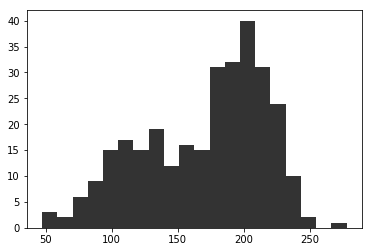

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(data_, bins=20, color="k", histtype="stepfilled", alpha=0.8)

In [14]:
import tensorflow as tf
import tensorflow_probability as tfp
tfe = tf.contrib.eager
tfd = tfp.distributions
sess = tf.InteractiveSession()

In [16]:
def evaluate(tensors):
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
        tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

In [18]:
tfd = tfp.distributions
p1 = tfd.Uniform(name='p', low=0., high=1.).sample()
p2 = 1 - p1
p = tf.stack([p1, p2])
assignment = tfd.Categorical(name="assignment", 
                             probs=p)   
assignment_ = evaluate(assignment.sample(sample_shape=data_.shape[0],
                                             seed=42))[:10]
print("prior assignment, with p = %.2f:" % evaluate(p1))
print("assigment evaluation: \n", assignment_)

prior assignment, with p = 0.93:
assigment evaluation: 
 [0 1 1 1 1 1 1 1 1 1]


In [19]:
rv_sds = tfd.Uniform(name="rv_sds", low=[0., 0.], high=[100., 100.])
rv_centers = tfd.Normal(name="rv_centers", loc=[120., 190.], scale=[10., 10.])
    
center_i = rv_centers.sample()
sd_i = rv_sds.sample()
rv_assignments = tfd.Categorical(probs=tf.stack([0.4, 0.6]))

assignment_ = evaluate(rv_assignments.sample(sample_shape=10))

# and to combine it with the observations:
rv_observations = tfd.MixtureSameFamily(
    mixture_distribution=rv_assignments,
    components_distribution=tfd.Normal(
        loc=center_i,
        scale=sd_i))

sim_data_ = evaluate(rv_observations.sample(sample_shape=10))
    
print("simulated data: ", sim_data_, "...")
print("Random assignments: ", assignment_, "...")
print("Assigned center: ", evaluate(center_i), "...")
print("Assigned standard deviation: ", evaluate(sd_i))

simulated data:  [148.29141  138.09518  206.17435  180.14973   87.037926 160.72534
 173.46252  127.52777  176.92375  221.4968  ] ...
Random assignments:  [1 0 0 1 1 0 1 0 1 0] ...
Assigned center:  [115.75471 174.34206] ...
Assigned standard deviation:  [45.54118 67.15618]


In [20]:
def joint_log_prob(data_, sample_prob_1, sample_centers, sample_sds):
    rv_prob = tfd.Uniform(name='rv_prob', low=0., high=1.)
    sample_prob_2 = 1. - sample_prob_1
    rv_assignments = tfd.Categorical(probs=tf.stack([sample_prob_1, sample_prob_2]))
    
    rv_sds = tfd.Uniform(name="rv_sds", low=[0., 0.], high=[100., 100.])
    rv_centers = tfd.Normal(name="rv_centers", loc=[120., 190.], scale=[10., 10.])
    
    rv_observations = tfd.MixtureSameFamily(mixture_distribution=rv_assignments,components_distribution=tfd.Normal(loc=sample_centers, scale=sample_sds))
    return (
        rv_prob.log_prob(sample_prob_1)
        + rv_prob.log_prob(sample_prob_2)
        + tf.reduce_sum(rv_observations.log_prob(data_))
        + tf.reduce_sum(rv_centers.log_prob(sample_centers))
        + tf.reduce_sum(rv_sds.log_prob(sample_sds))
    )
    sum_log_prob = tf.reduce_sum(tf.concat(log_prob_parts, axis=-1), axis=-1)
    return sum_log_prob

In [21]:
number_of_steps=25000
burnin=1000

initial_chain_state = [
    tf.constant(0.5, name='init_probs'),
    tf.constant([120., 190.], name='init_centers'),
    tf.constant([10., 10.], name='init_sds')
]

unconstraining_bijectors = [
    tfp.bijectors.Identity(),       
    tfp.bijectors.Identity(),       
    tfp.bijectors.Identity(), 
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(data_, *args)

with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=2,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

[
    posterior_prob,
    posterior_centers,
    posterior_sds
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc)

# Initialize any created variables.
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

In [22]:

evaluate(init_g)
evaluate(init_l)
[
    posterior_prob_,
    posterior_centers_,
    posterior_sds_,
    kernel_results_
] = evaluate([
    posterior_prob,
    posterior_centers,
    posterior_sds,
    kernel_results
])
    
new_step_size_initializer_ = kernel_results_.inner_results.is_accepted.mean()
print("acceptance rate: {}".format(
    new_step_size_initializer_))
new_step_size_initializer_
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.62716
final step size: 0.05703594535589218


In [25]:
class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

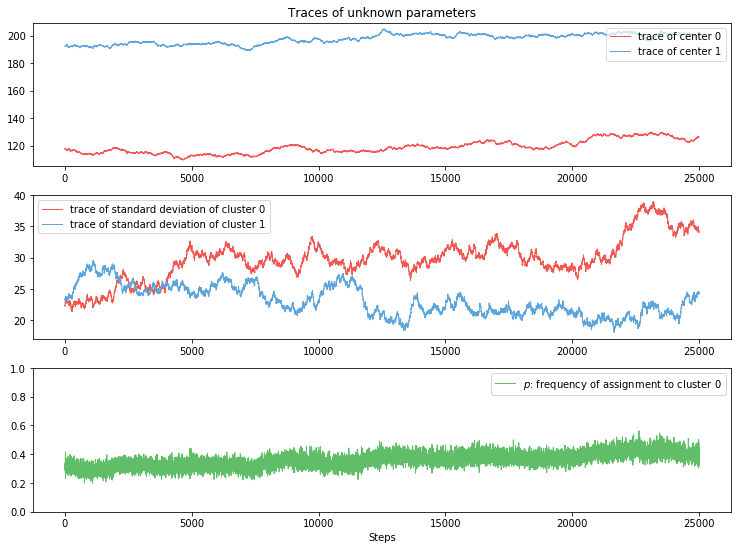

In [27]:
from IPython.core.pylabtools import figsize
plt.figure(figsize(12.5, 9))
plt.subplot(311)
lw = 1
center_trace = posterior_centers_

# for pretty colors later in the book.
colors = [TFColor[3], TFColor[0]] if center_trace[-1, 0] > center_trace[-1, 1] \
    else [TFColor[0], TFColor[3]]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = posterior_sds_
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = posterior_prob_
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=TFColor[2], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

In [28]:
number_of_steps=50000 
burnin=0 

initial_chain_state = [
    tf.constant(posterior_prob_[-1], name='init_probs_2'),
    tf.constant(posterior_centers_[-1], name='init_centers_2'),
    tf.constant(posterior_sds_[-1], name='init_sds_2')
]


with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size_2',
        #initializer=tf.constant(new_step_size_initializer_, dtype=tf.float32),
        initializer=tf.constant(0.5, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=2,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

[
    posterior_prob_2,
    posterior_centers_2,
    posterior_sds_2
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc)

init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()

evaluate(init_g)
evaluate(init_l)
[
    posterior_prob_2_,
    posterior_centers_2_,
    posterior_sds_2_,
    kernel_results_
] = evaluate([
    posterior_prob_2,
    posterior_centers_2,
    posterior_sds_2,
    kernel_results
])

print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
new_step_size_initializer_
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.62286
final step size: 0.053933728486299515


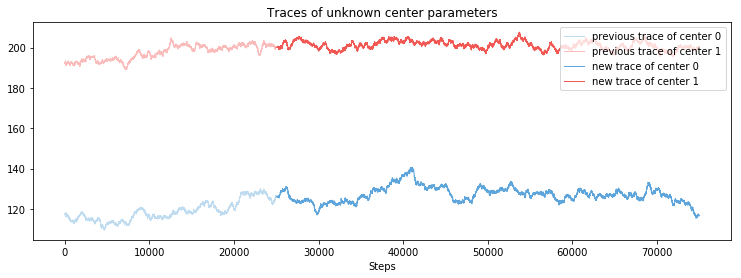

In [29]:
plt.figure(figsize(12.5, 4))
center_trace = posterior_centers_2_
prev_center_trace = posterior_centers_

x = np.arange(25000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(25000, 75000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0", lw=lw, c="#5DA5DA")
plt.plot(x, center_trace[:, 1], label="new trace of center 1", lw=lw, c="#F15854")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

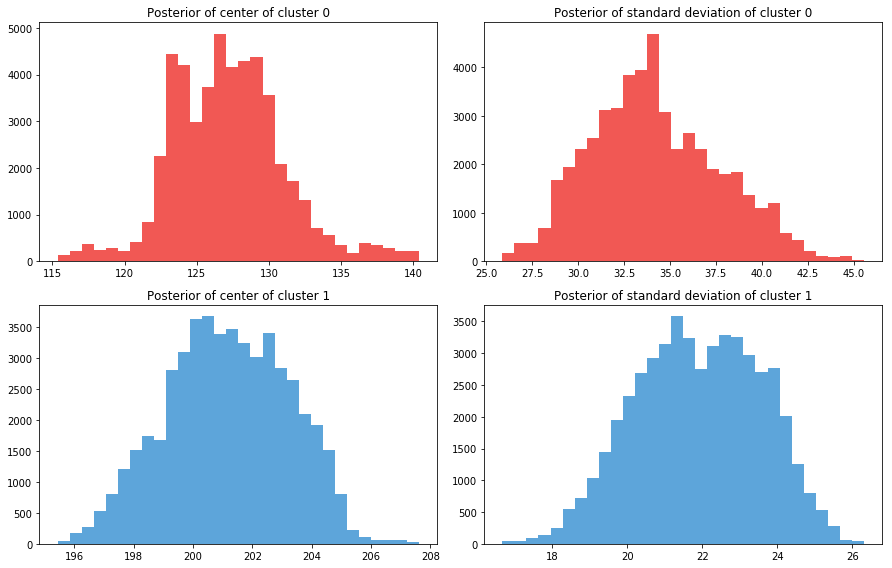

In [30]:
plt.figure(figsize(12.5, 8))
std_trace = posterior_sds_2_
prev_std_trace = posterior_sds_

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

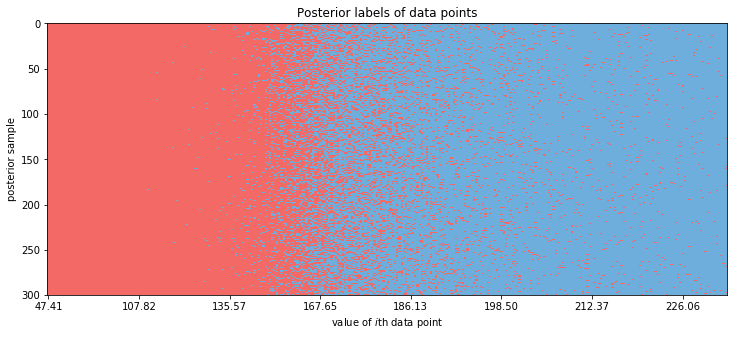

In [32]:
import matplotlib as mpl
posterior_center_means = evaluate(tf.reduce_mean(posterior_centers_2_, axis=0))
posterior_std_means = evaluate(tf.reduce_mean(posterior_sds_2_, axis=0))
posterior_prob_mean = evaluate(tf.reduce_mean(posterior_prob_2_, axis=0))
dist_0 = tfd.Normal(loc=posterior_center_means[0], scale=posterior_std_means[0])
dist_1 = tfd.Normal(loc=posterior_center_means[1], scale=posterior_std_means[1])
prob_assignment_0 = dist_0.prob(data_)
prob_assignment_1 = dist_1.prob(data_)
probs_assignments = tf.subtract(1., tf.div(prob_assignment_1, 
                           tf.add_n([prob_assignment_0, 
                                    prob_assignment_1])))
probs_assignments_inv = tf.subtract(1., probs_assignments)
cluster_probs = tf.transpose(tf.stack([probs_assignments, probs_assignments_inv]))

burned_assignment_trace_ = evaluate(tfd.Categorical(probs=cluster_probs).sample(sample_shape=300))

plt.figure(figsize(12.5, 5))
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(burned_assignment_trace_[:, np.argsort(data_)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data_.shape[0], 40),
       ["%.2f" % s for s in np.sort(data_)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");